In [171]:
import cv2
from skimage import io
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

**Input Image**

I have placed the image in the github repository and reading from there

In [172]:
image_path = "https://raw.githubusercontent.com/Srigowri/Classical-Image-Processing/main/assests/circuit.jpg"
image = io.imread(image_path)

# #show thei image
# fig = plt.figure(figsize=(10,10))
# plt.axis("off")
# plt.imshow(image)


Using the gray scale of the image for this experiment

Resized the image to a smaller dimension

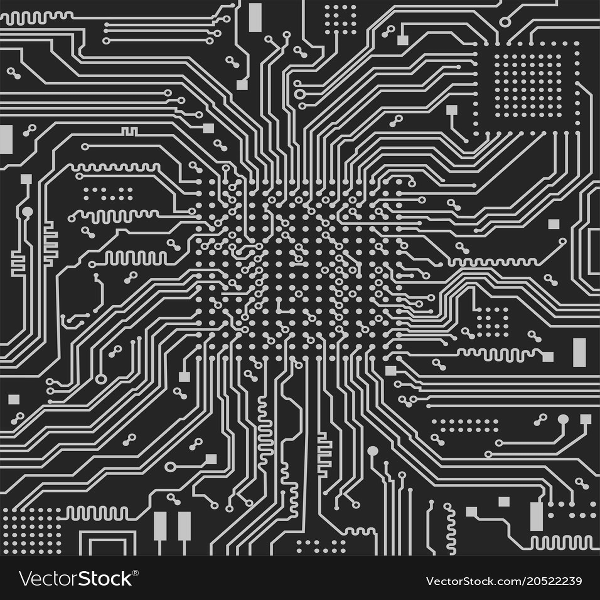

In [173]:
cv2.imwrite("./waveletTransform.jpeg",image)
img = cv2.imread("/content/waveletTransform.jpeg",cv2.IMREAD_GRAYSCALE)
img  =cv2.resize(img,(600,600),interpolation=cv2.INTER_CUBIC)
cv2_imshow(img)

# **Decomposition**

In [174]:

#Daubechies-2 low pass filter
h0 = -0.1294095226
h1 =  0.2241438680
h2 =  0.8365163037
h3 =  0.4829629131

#Daubechies-2 high pass filter
g0 = -0.4829629131
g1 =  0.8365163037
g2 = -0.2241438680
g3 = -0.1294095226


db2_lowpass = [h0,h1,h2,h3]
db2_highpass = [g0,g1,g2,g3]

In [175]:
M = img.shape[0]
N = img.shape[1]

L = len(db2_lowpass)
H = len(db2_highpass)

print("Image size is {}*{} \nThe filter sizes are {} and {}".format(M,N,L,H))

Image size is 600*600 
The filter sizes are 4 and 4


# **Convolution along rows and subsampling**

In [176]:
L0 = np.zeros((M,N+H-1))
H0 = np.zeros((M,N+H-1))

print("Before convolution",M,N)

for index,row in enumerate(img):
    L0[index] = np.convolve(row,db2_lowpass)
    H0[index] = np.convolve(row,db2_highpass)

print("After convolution along rows L0 size",L0.shape,"H0 size", H0.shape)

#Downsampling to produce the scaling effect
L0 = L0[:,1::2]
H0 = H0[:,1::2]

print("After subsampling the columns L0 size",L0.shape,"H0 size", H0.shape)

Before convolution 600 600
After convolution along rows L0 size (600, 603) H0 size (600, 603)
After subsampling the columns L0 size (600, 301) H0 size (600, 301)


# **LL and LH**

In [177]:
print("Convolving along columns")

#We need to do the convolution along columns,
#I have taken the transpose of the previous steps and convolved
colL = L0.T 
LL = np.zeros((colL.shape[0],colL.shape[1]+L-1))
LH = np.zeros((colL.shape[0],colL.shape[1]+H-1))
for index,col in enumerate(colL):
    LL[index] = np.convolve(col,db2_lowpass)
    LH[index] = np.convolve(col,db2_highpass)

#Downsampling to produce the scaling effect
#Once downsampled take back the transpose to get it original form
LL1 = LL[:,1::2].T
LH1 = LH[:,1::2].T

print("After subsampling along rows LL1 size",LL1.shape)

Convolving along columns
After subsampling along rows LL1 size (301, 301)


# **HL and HH**

In [178]:
print("Convolving along columns")

#We need to do the convolution along columns,
#I have taken the transpose of the previous steps and convolved
colH = H0.T
HL = np.zeros((colH.shape[0],colH.shape[1]+L-1))
HH = np.zeros((colH.shape[0],colH.shape[1]+H-1))
for index,col in enumerate(colH):
    HL[index] = np.convolve(col,db2_lowpass)
    HH[index] = np.convolve(col,db2_highpass)

#Downsampling to produce the scaling effect
HL1 = HL[:,1::2].T
HH1 = HH[:,1::2].T
print("After subsampling along rows HL",HL1.shape)

Convolving along columns
After subsampling along rows HL (301, 301)


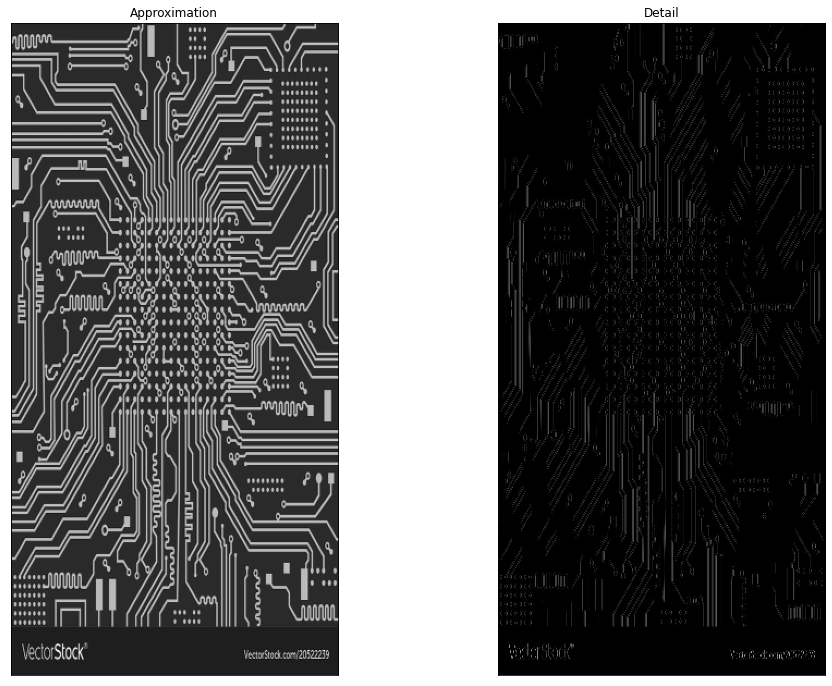

In [179]:
fig,axes =  plt.subplots(1,2,figsize=(16,12))
axes[0].imshow(L0,cmap='gray')
axes[0].set_title("Approximation")
axes[1].imshow(H0,cmap='gray',vmin=0,vmax=255)
axes[1].set_title("Detail")
axes[0].set_xticks([]);axes[1].set_xticks([])
axes[0].set_yticks([]);axes[1].set_yticks([])
plt.show()

# **Plotting the four subbands**

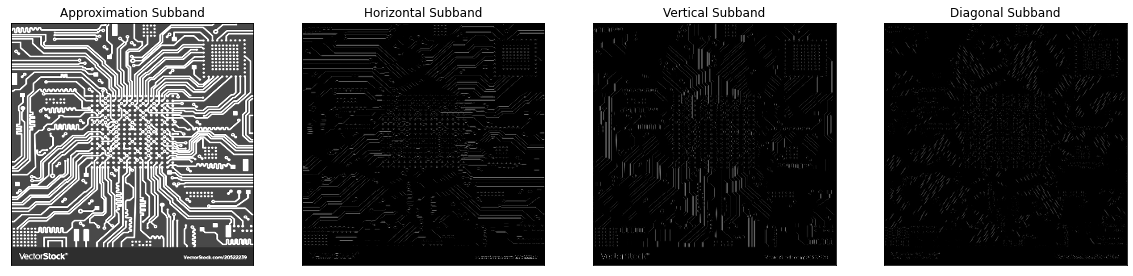

In [180]:
fig,axes =  plt.subplots(1,4,figsize=(20,16))
axes[0].imshow(LL1,cmap='gray',vmin=0,vmax=255)
axes[0].set_title("Approximation Subband")
axes[1].imshow(LH1,cmap='gray',vmin=0,vmax=255)
axes[1].set_title("Horizontal Subband")
axes[2].imshow(HL1,cmap='gray',vmin=0,vmax=255)
axes[2].set_title("Vertical Subband")
axes[3].imshow(HH1,cmap='gray',vmin=0,vmax=255)
axes[3].set_title("Diagonal Subband")

axes[0].set_xticks([]);axes[1].set_xticks([]);axes[2].set_xticks([]);axes[3].set_xticks([]);
axes[0].set_yticks([]);axes[1].set_yticks([]);axes[2].set_yticks([]);axes[3].set_yticks([]);
plt.show()

# **Reconstruction**

In [181]:
#add columns

#L0 - Low pass
#H0 - high pass

i_h0 = 0.48296291314469025
i_h1 = 0.836516303737469
i_h2 = 0.22414386804185735
i_h3 = -0.12940952255092145

i_g0 = -0.12940952255092145
i_g1 = -0.22414386804185735
i_g2 = 0.836516303737469
i_g3 = -0.48296291314469025

i_db2_low_pass = [i_h0,i_h1,i_h2,i_h3]
i_db2_high_pass = [i_g0,i_g1,i_g2,i_g3]

L = len(i_db2_low_pass)
H = len(i_db2_high_pass)

# **1.Upsampling by adding rows to the four subbands**

In [182]:
#upsample rows before performing conv along columns
I_LL1 = np.zeros((LL1.shape[0]*2,LL1.shape[1]))
I_LH1 = np.zeros((LH1.shape[0]*2,LH1.shape[1]))

I_HL1 = np.zeros((HL1.shape[0]*2,HL1.shape[1]))
I_HH1 = np.zeros((HH1.shape[0]*2,HH1.shape[1]))


#fill alternate rows of I_LL1 with the values of LL1
I_LL1[0::2,] = LL1
I_LH1[0::2,] = LH1
I_HL1[0::2,] = HL1
I_HH1[0::2,] = HH1

print("Before upsampling rows",LL1.shape,HH1.shape)
print("After upsampling rows",I_LL1.shape,I_HH1.shape)

Before upsampling rows (301, 301) (301, 301)
After upsampling rows (602, 301) (602, 301)


# **2. Convolution + Addition**

In [183]:
#perform convolution along columns

#number of rows would increase
I_LL = np.zeros((I_LL1.T.shape[0],I_LL1.T.shape[1]+L-1))
for index,row in enumerate(I_LL1.T):
    I_LL[index] = np.convolve(row,i_db2_low_pass)

I_LH = np.zeros((I_LH1.T.shape[0],I_LH1.T.shape[1]+H-1))
for index,row in enumerate(I_LH1.T):
    I_LH[index] = np.convolve(row,i_db2_high_pass)

I_HL = np.zeros((I_HL1.T.shape[0],I_HL1.T.shape[1]+L-1))
for index,row in enumerate(I_HL1.T):
    I_HL[index] = np.convolve(row,i_db2_low_pass)

I_HH = np.zeros((I_HH1.T.shape[0],I_HH1.T.shape[1]+H-1))
for index,row in enumerate(I_HH1.T):
    I_HH[index] = np.convolve(row,i_db2_high_pass)

I_LL = I_LL.T
I_LH = I_LH.T

I_HL = I_HL.T
I_HH = I_HH.T

print("After convolution across columns, the no of rows must increase",I_LL1.shape,I_LL.shape)

print("Combining the results")
I_L0 = I_LL + I_LH
I_H0 = I_HL + I_HH

After convolution across columns, the no of rows must increase (602, 301) (605, 301)
Combining the results


# **3 .Upsampling the columns & Convolution along the rows**

In [184]:
#add 0 columns to this and pass it to low pass

I_L_ = np.zeros((I_L0.shape[0],I_L0.shape[1]*2))
I_H_ = np.zeros((I_H0.shape[0],I_H0.shape[1]*2))

I_L_[:,0::2] = I_L0
I_H_[:,0::2] = I_H0


print("Before upsampling colums",I_L0.shape,I_H0.shape)
print("After upsampling columns",I_L_.shape,I_L_.shape)

#prepare matrix for convolution with more columns
I_L = np.zeros((I_L_.shape[0],I_L_.shape[1]+L-1))
I_H = np.zeros((I_H_.shape[0],I_H_.shape[1]+H-1))

for index,row in enumerate(I_L_):
    I_L[index] = np.convolve(row,i_db2_low_pass)

for index,row in enumerate(I_H_):
    I_H[index] = np.convolve(row,i_db2_high_pass)

print("After convolution across rows, the no of columns must increase",I_LL1.shape,I_L.shape)



Before upsampling colums (605, 301) (605, 301)
After upsampling columns (605, 602) (605, 602)
After convolution across rows, the no of columns must increase (602, 301) (605, 605)


# **4. Combining the approximation and detail**

In [185]:
I = I_L+I_H

# **Reconstructed Image**

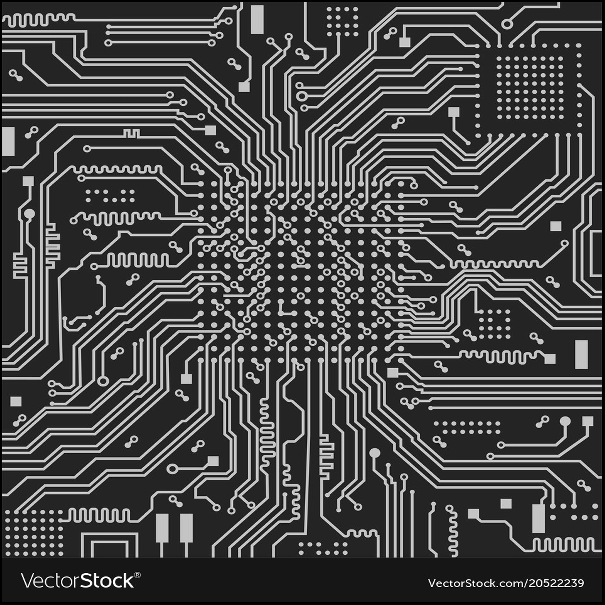

In [186]:
cv2_imshow(I)

# **Plotting intermediary results of reconstruction**

In [187]:
def plot_subbands(img1,img2,img3,img4,title):
    fig,axes =  plt.subplots(1,4,figsize=(16,12))
    plt.suptitle(title,y=0.81,fontsize=15)
    axes[0].imshow(img1,cmap='gray',vmin=0,vmax=255)
    axes[0].set_title("Approximation Subband")
    axes[1].imshow(img2,cmap='gray',vmin=0,vmax=255)
    axes[1].set_title("Horizontal Subband")
    axes[2].imshow(img3,cmap='gray',vmin=0,vmax=255)
    axes[2].set_title("Vertical Subband")
    axes[3].imshow(img4,cmap='gray',vmin=0,vmax=255)
    axes[3].set_title("Diagonal Subband")

    axes[0].set_xticks([]);axes[1].set_xticks([]);axes[2].set_xticks([]);axes[3].set_xticks([]);
    axes[0].set_yticks([]);axes[1].set_yticks([]);axes[2].set_yticks([]);axes[3].set_yticks([]);
    plt.show()

# i_bands11 = cv2.hconcat([I_L0,I_H0])
# cv2_imshow(i_bands11)
def plot_bands(img1,img2,title):
    fig,axes =  plt.subplots(1,2,figsize=(16,12))
    plt.suptitle(title,y=0.81,fontsize=15)
    axes[0].imshow(img1,cmap='gray',vmin=0,vmax=255)
    axes[0].set_title("Reconstructed Approximation")
    axes[1].imshow(img2,cmap='gray',vmin=0,vmax=255)
    axes[1].set_title("Reconstructed Detail")
    axes[0].set_xticks([]);axes[1].set_xticks([])
    axes[0].set_yticks([]);axes[1].set_yticks([])
    plt.show()

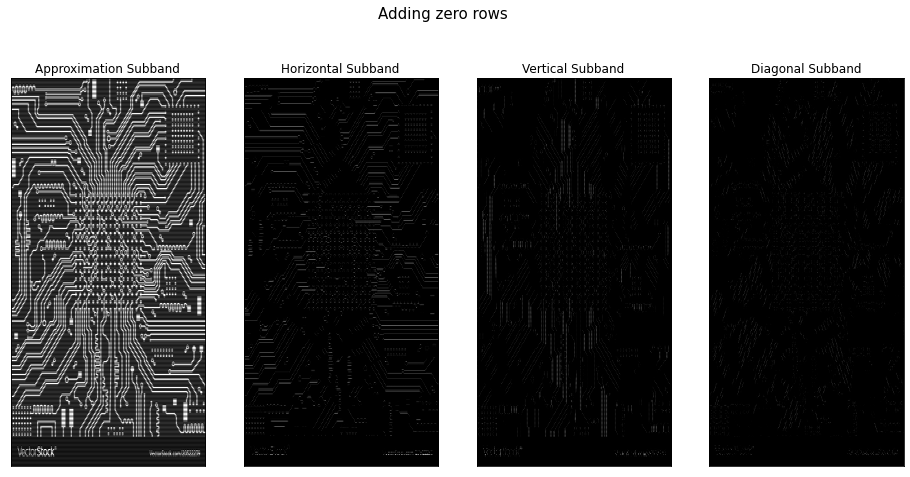

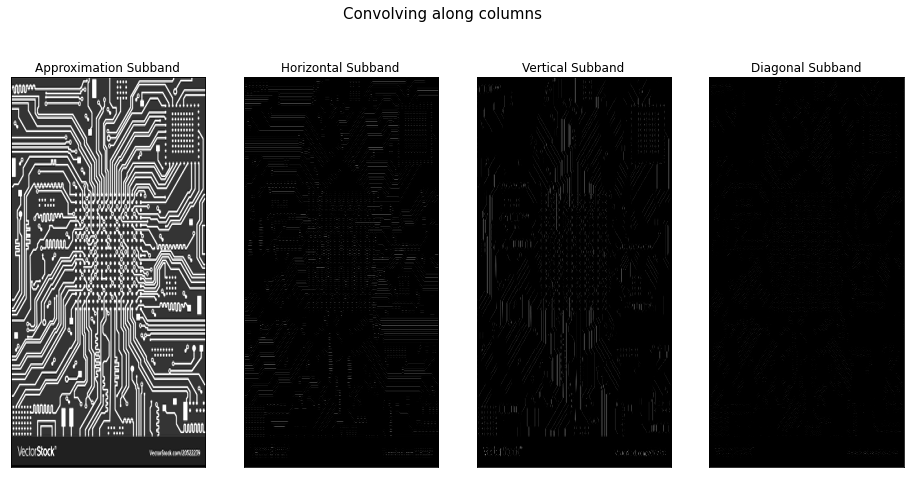

In [188]:
plot_subbands(I_LL1,I_LH1,I_HL1,I_HH1,title="Adding zero rows")
plot_subbands(I_LL,I_LH,I_HL,I_HH,title="Convolving along columns")

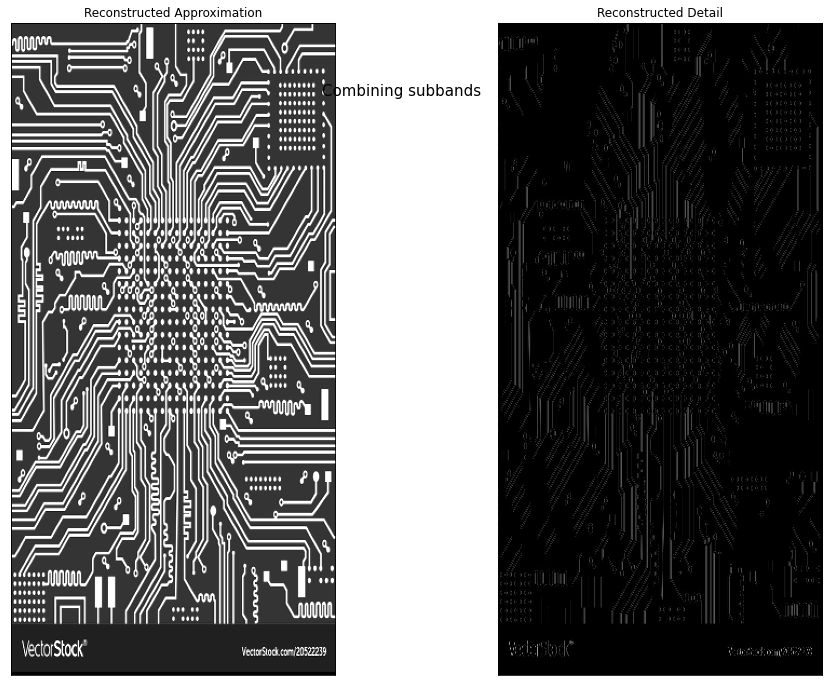

In [189]:
plot_bands(I_L0,I_H0,title="Combining subbands")
#scroll to see all plots

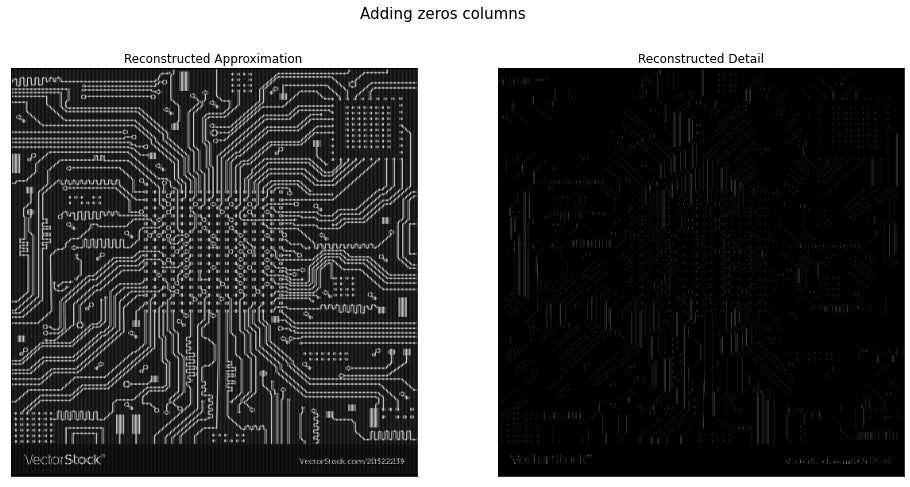

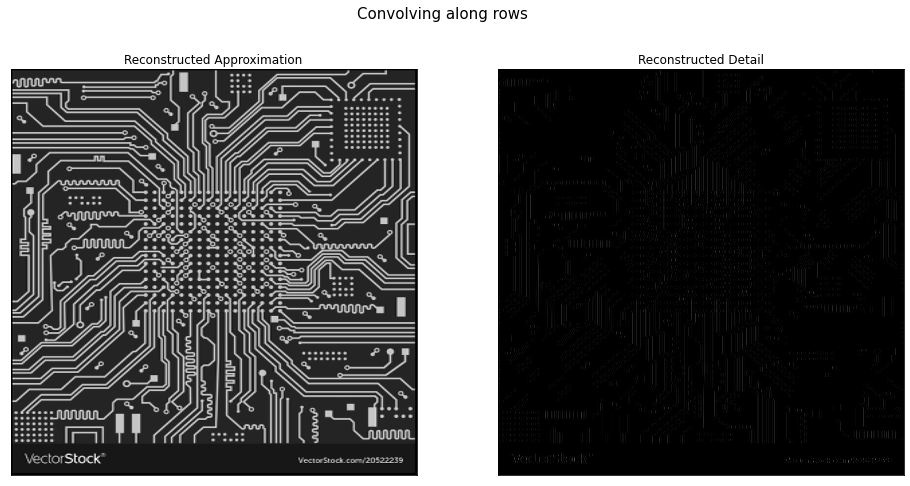

In [190]:
plot_bands(I_L_,I_H_,title="Adding zeros columns")
plot_bands(I_L,I_H,title="Convolving along rows")

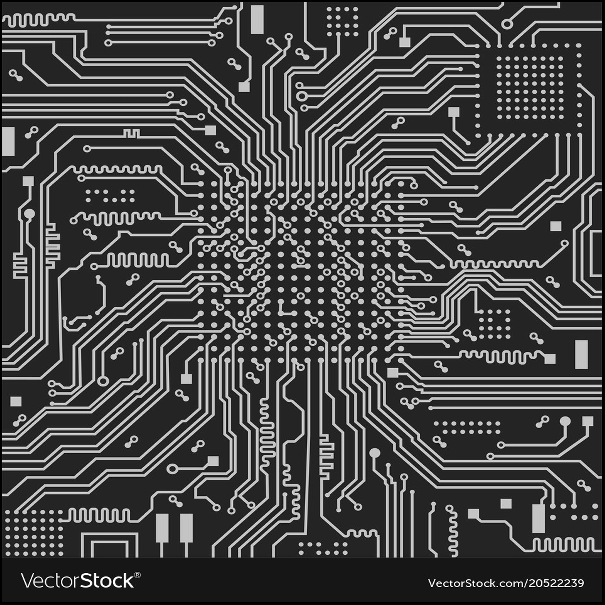

In [191]:
#combining approximation and detail
#Reconstructed image
cv2_imshow(I)